# Steering Vector Analysis - Key Figures

Minimal notebook showing key visualizations:
1. Glass's delta effect size heatmap
2. Logit diff violin plots at best layers
3. Steering effectiveness over layer fraction
4. Generation evaluation valid response rates by model size and steering strength

In [2]:
import json
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

In [16]:
BASE_DIR = Path(os.path.expanduser("~/p/steering/results/logit_diff_sweep"))

MODELS = ["4B", "8B", "14B", "32B", "30B-A3B", "235B-A22B"]
CONCEPTS = ["corrigible", "self_awareness", "sycophancy", "survival_instinct", "power_seeking_inclination"]

print(f"Loading from: {BASE_DIR}")

Loading from: /home/omar-ayyub/p/steering/results/logit_diff_sweep


In [17]:
# Load all layer summaries and sample data
all_summaries = []
all_samples = []

for model in MODELS:
    # Convert dashes to underscores for directory name (e.g., "30B-A3B" -> "30B_A3B")
    model_dir = f"Qwen_Qwen3_{model.replace('-', '_')}"
    
    for concept in CONCEPTS:
        summary_path = BASE_DIR / concept / model_dir / "layer_summary.csv"
        samples_path = BASE_DIR / concept / model_dir / "per_sample_all_layers.csv"
        
        if summary_path.exists():
            df = pd.read_csv(summary_path)
            df["model"] = model
            df["concept"] = concept
            all_summaries.append(df)
        
        if samples_path.exists():
            df = pd.read_csv(samples_path)
            # File already has model/concept columns, overwrite to ensure consistent naming
            df["model"] = model
            df["concept"] = concept
            all_samples.append(df)

summary_df = pd.concat(all_summaries, ignore_index=True) if all_summaries else pd.DataFrame()
samples_df = pd.concat(all_samples, ignore_index=True) if all_samples else pd.DataFrame()

print(f"Loaded {len(summary_df)} layer summaries")
print(f"Loaded {len(samples_df)} individual samples")
print(f"Models: {summary_df['model'].unique().tolist()}")
print(f"Concepts: {summary_df['concept'].unique().tolist()}")

Loaded 1017 layer summaries
Loaded 266220 individual samples
Models: ['4B', '8B', '14B', '32B', '30B-A3B', '235B-A22B']
Concepts: ['corrigible', 'self_awareness', 'sycophancy', 'survival_instinct', 'power_seeking_inclination']


In [18]:
# Find best layer for each model/concept (highest delta)
best_layers = summary_df.loc[summary_df.groupby(["model", "concept"])["delta"].idxmax()][["model", "concept", "layer", "delta"]]
best_layers = best_layers.rename(columns={"layer": "best_layer", "delta": "best_delta"})

# Get samples at best layers only
best_samples = samples_df.merge(best_layers, on=["model", "concept"])
best_samples = best_samples[best_samples["layer"] == best_samples["best_layer"]]

print(f"Best layer samples: {len(best_samples)}")
display(best_layers)

Best layer samples: 7620


,model,concept,best_layer,best_delta
257,14B,corrigible,20,10.256413
368,14B,power_seeking_inclination,23,4.057122
289,14B,self_awareness,25,9.367011
340,14B,survival_instinct,22,0.491250
316,14B,sycophancy,25,3.009375
810,235B-A22B,corrigible,76,5.919827
999,235B-A22B,power_seeking_inclination,76,7.212217
873,235B-A22B,self_awareness,76,5.365729
930,235B-A22B,survival_instinct,70,5.246201
611,30B-A3B,corrigible,26,13.873859


## 1. Glass's Delta Effect Size Heatmap

Glass's delta uses only the control group's standard deviation (negative steering) as the denominator,
rather than the pooled std used in Cohen's d. This is more appropriate when groups may have different variances.

In [19]:
# Calculate Glass's delta for each model/concept
glass_deltas = []

for model in MODELS:
    for concept in CONCEPTS:
        data = best_samples[(best_samples["model"] == model) & (best_samples["concept"] == concept)]
        
        if len(data) == 0:
            continue
            
        pos = data[data["strength"] == 1.0]["logit_diff_matching"]
        neg = data[data["strength"] == -1.0]["logit_diff_matching"]
        
        if len(pos) == 0 or len(neg) == 0:
            continue
        
        mean_diff = pos.mean() - neg.mean()
        # Glass's delta: use control (negative) std only
        glass_d = mean_diff / neg.std() if neg.std() > 0 else 0
        
        glass_deltas.append({
            "model": model,
            "concept": concept,
            "mean_positive": pos.mean(),
            "mean_negative": neg.mean(),
            "std_negative": neg.std(),
            "delta": mean_diff,
            "glass_delta": glass_d,
        })

glass_df = pd.DataFrame(glass_deltas)
print("Glass's Delta Effect Sizes:")
display(glass_df.round(3))

Glass's Delta Effect Sizes:


,model,concept,mean_positive,mean_negative,std_negative,delta,glass_delta
0,4B,corrigible,7.905,-6.107,10.910,14.011,1.284
1,4B,self_awareness,3.992,-4.840,4.660,8.832,1.895
2,4B,sycophancy,5.941,1.349,4.581,4.592,1.002
3,4B,survival_instinct,-1.056,-1.987,4.694,0.931,0.198
4,4B,power_seeking_inclination,3.300,-6.309,6.251,9.609,1.537
5,8B,corrigible,6.179,-1.603,7.687,7.782,1.012
6,8B,self_awareness,5.198,-3.621,8.279,8.819,1.065
7,8B,sycophancy,2.968,1.474,2.577,1.493,0.579
8,8B,survival_instinct,-0.491,-1.450,4.406,0.959,0.218
9,8B,power_seeking_inclination,1.575,-1.542,6.220,3.117,0.501


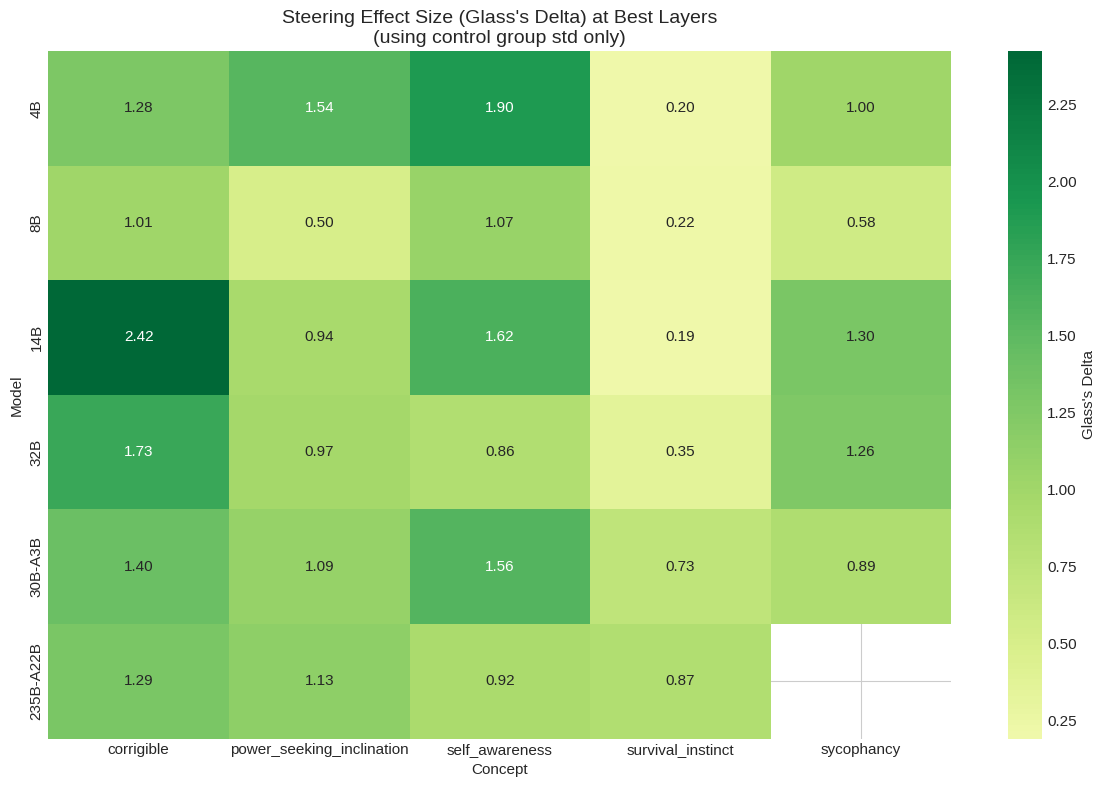

In [20]:
# Glass's delta heatmap
pivot = glass_df.pivot(index="model", columns="concept", values="glass_delta")
pivot = pivot.reindex(MODELS)

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="RdYlGn", center=0, ax=ax,
            cbar_kws={"label": "Glass's Delta"}, mask=pivot.isna())
ax.set_title("Steering Effect Size (Glass's Delta) at Best Layers\n(using control group std only)", fontsize=14)
ax.set_ylabel("Model")
ax.set_xlabel("Concept")
plt.tight_layout()
plt.savefig("../results/logit_diff_sweep/glass_delta_heatmap.png", dpi=150, bbox_inches="tight")
plt.show()

## 2. Logit Diff Violin Plots

Distribution of per-sample logit differences at the best layer for each model/concept,
showing both positive (+1.0) and negative (-1.0) steering strengths.

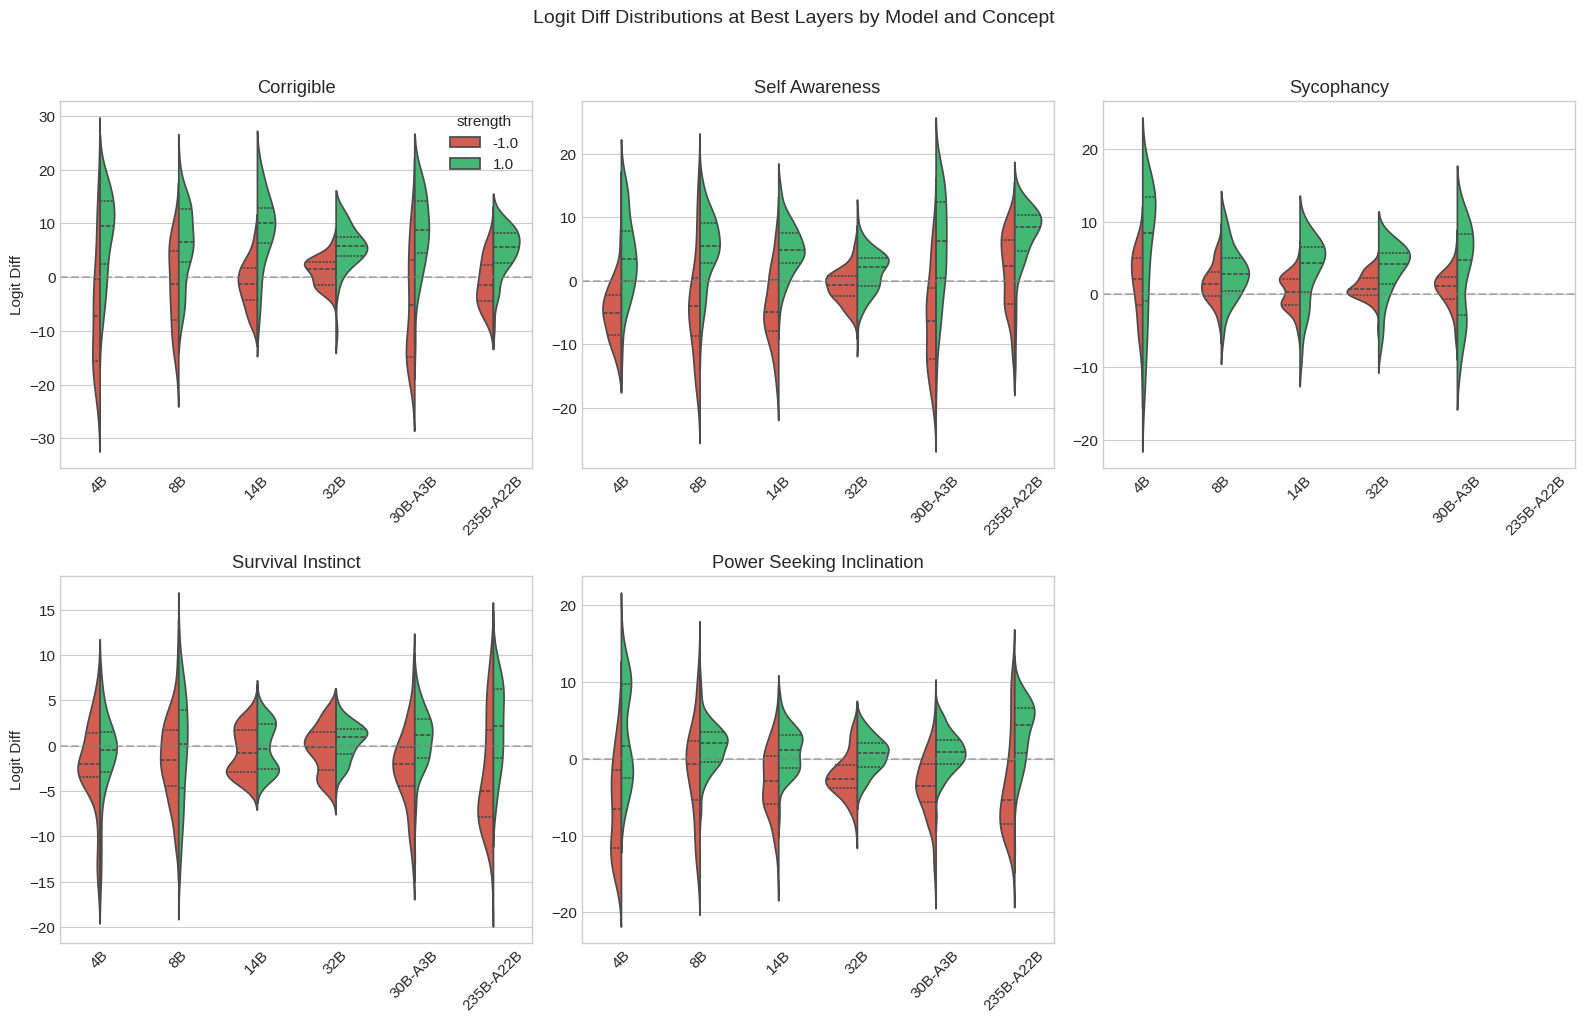

In [8]:
# Violin plots of logit diff distributions at best layers
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for i, concept in enumerate(CONCEPTS[:6]):  # Up to 6 concepts
    if i >= len(axes):
        break
    ax = axes[i]
    
    data = best_samples[(best_samples["concept"] == concept) & 
                        (best_samples["strength"].isin([-1.0, 1.0]))]
    
    if len(data) > 0:
        sns.violinplot(
            data=data, x="model", y="logit_diff_matching", hue="strength",
            split=True, ax=ax, palette={-1.0: "#E74C3C", 1.0: "#2ECC71"},
            order=MODELS, inner="quartile"
        )
        ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
        ax.set_title(concept.replace("_", " ").title())
        ax.set_xlabel("")
        ax.set_ylabel("Logit Diff" if i % 3 == 0 else "")
        ax.tick_params(axis='x', rotation=45)
        if i > 0:
            ax.get_legend().remove()
    else:
        ax.set_visible(False)

# Hide unused axes
for j in range(len(CONCEPTS), len(axes)):
    axes[j].set_visible(False)

plt.suptitle("Logit Diff Distributions at Best Layers by Model and Concept", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig("../results/logit_diff_sweep/logit_diff_violins.png", dpi=150, bbox_inches="tight")
plt.show()

## 3. Steering Effectiveness Over Layer Fraction

How steering delta varies across relative layer depth (as fraction of total layers).
This normalizes across models with different layer counts.

In [22]:
# Add layer fraction to summary data
MODEL_LAYERS = {
    "4B": 36, "8B": 36, "14B": 40, "32B": 64,
    "30B-A3B": 48, "235B-A22B": 94
}

summary_df["total_layers"] = summary_df["model"].map(MODEL_LAYERS)
summary_df["layer_frac"] = summary_df["layer"] / summary_df["total_layers"]

print("Layer fraction range:", summary_df["layer_frac"].min(), "-", summary_df["layer_frac"].max())

Layer fraction range: 0.3055555555555556 - 0.9893617021276596


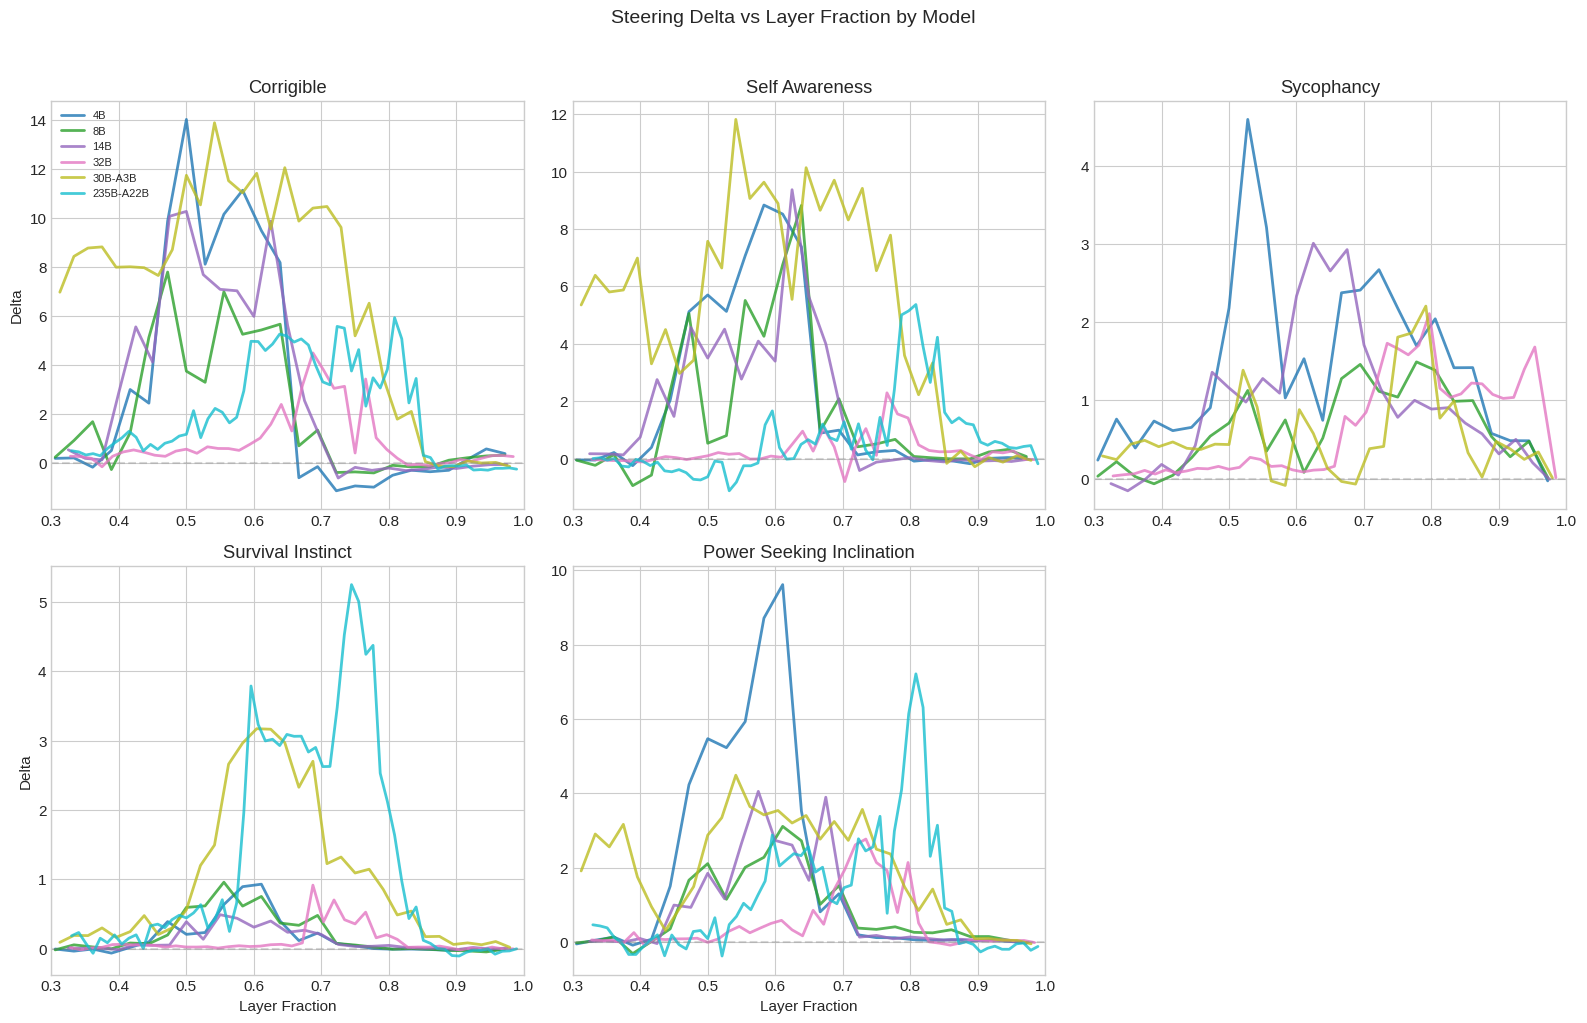

In [10]:
# Steering delta over layer fraction - one subplot per concept
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

colors = plt.cm.tab10(np.linspace(0, 1, len(MODELS)))
model_colors = dict(zip(MODELS, colors))

for i, concept in enumerate(CONCEPTS[:6]):
    if i >= len(axes):
        break
    ax = axes[i]
    
    for model in MODELS:
        data = summary_df[(summary_df["concept"] == concept) & (summary_df["model"] == model)]
        if len(data) > 0:
            ax.plot(data["layer_frac"], data["delta"], 
                   label=model, color=model_colors[model], linewidth=2, alpha=0.8)
    
    ax.set_title(concept.replace("_", " ").title())
    ax.set_xlabel("Layer Fraction" if i >= 3 else "")
    ax.set_ylabel("Delta" if i % 3 == 0 else "")
    ax.set_xlim(0.3, 1.0)
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    
    if i == 0:
        ax.legend(loc='upper left', fontsize=8)

# Hide unused axes
for j in range(len(CONCEPTS), len(axes)):
    axes[j].set_visible(False)

plt.suptitle("Steering Delta vs Layer Fraction by Model", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig("../results/logit_diff_sweep/delta_by_layer_fraction.png", dpi=150, bbox_inches="tight")
plt.show()

/tmp/ipykernel_849472/2030604016.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary_df = summary_df.groupby(["model", "concept"], group_keys=False).apply(normalize_delta)


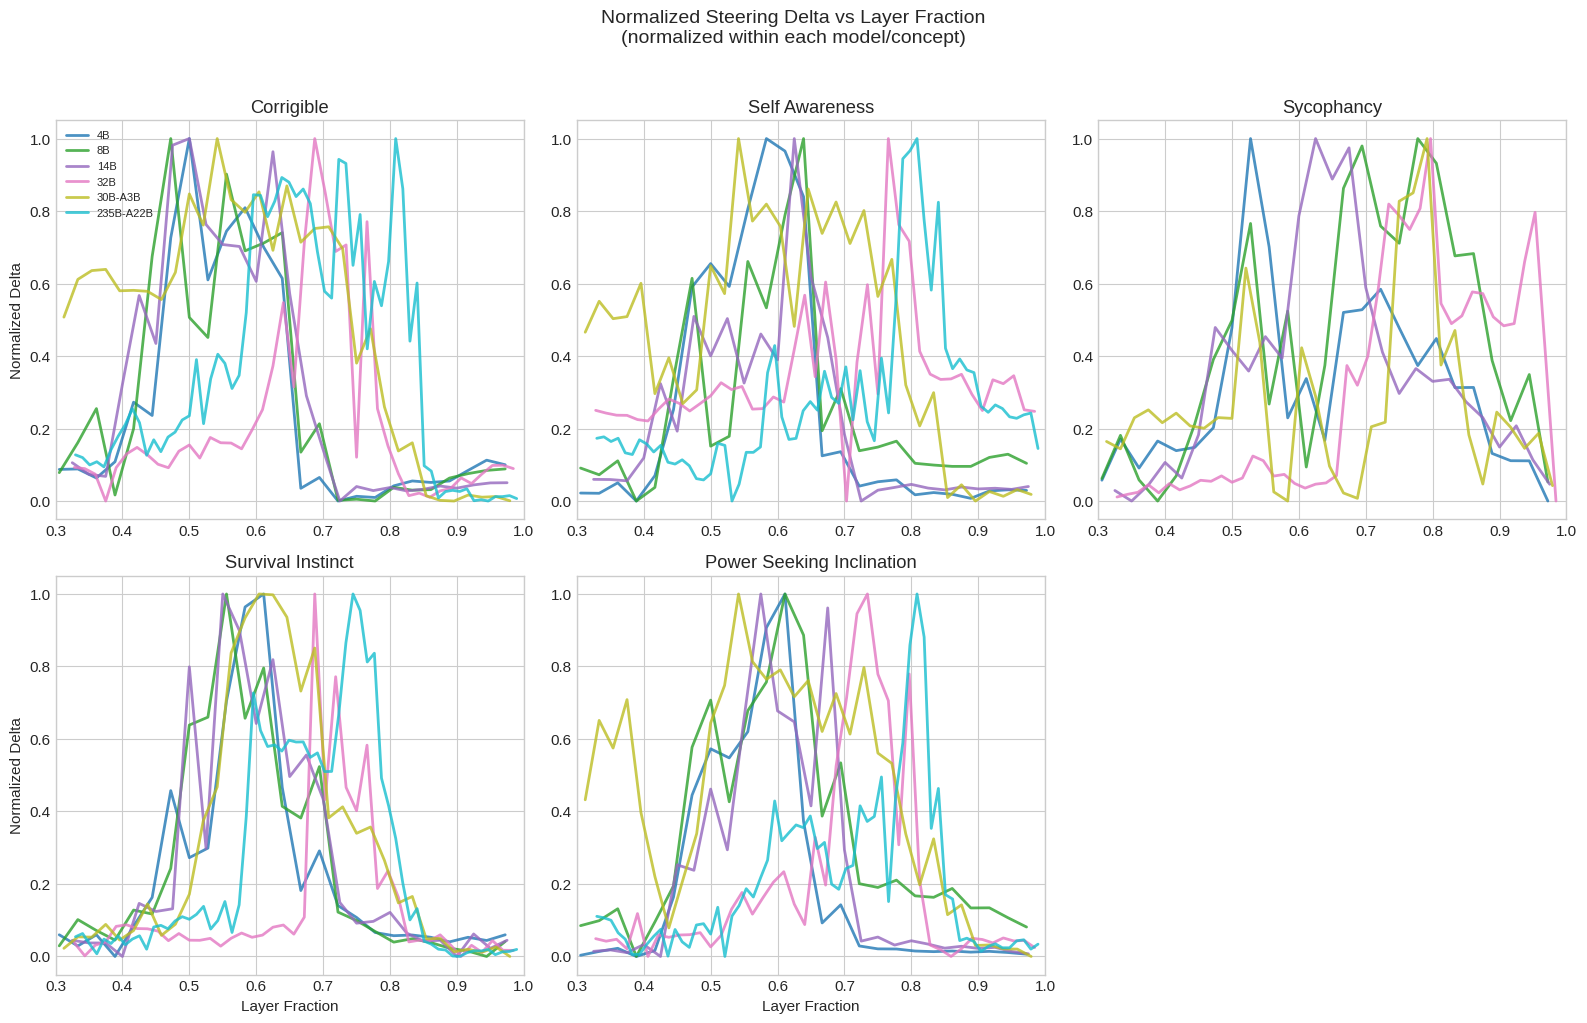

In [24]:
# Normalized delta (0-1 within each model/concept) over layer fraction
def normalize_delta(group):
    min_d, max_d = group["delta"].min(), group["delta"].max()
    if max_d > min_d:
        group["delta_norm"] = (group["delta"] - min_d) / (max_d - min_d)
    else:
        group["delta_norm"] = 0.5
    return group

summary_df = summary_df.groupby(["model", "concept"], group_keys=False).apply(normalize_delta)

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for i, concept in enumerate(CONCEPTS[:6]):
    if i >= len(axes):
        break
    ax = axes[i]
    
    for model in MODELS:
        data = summary_df[(summary_df["concept"] == concept) & (summary_df["model"] == model)]
        if len(data) > 0:
            ax.plot(data["layer_frac"], data["delta_norm"], 
                   label=model, color=model_colors[model], linewidth=2, alpha=0.8)
    
    ax.set_title(concept.replace("_", " ").title())
    ax.set_xlabel("Layer Fraction" if i >= 3 else "")
    ax.set_ylabel("Normalized Delta" if i % 3 == 0 else "")
    ax.set_xlim(0.3, 1.0)
    ax.set_ylim(-0.05, 1.05)
    
    if i == 0:
        ax.legend(loc='upper left', fontsize=8)

# Hide unused axes
for j in range(len(CONCEPTS), len(axes)):
    axes[j].set_visible(False)

plt.suptitle("Normalized Steering Delta vs Layer Fraction\n(normalized within each model/concept)", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig("../results/logit_diff_sweep/delta_norm_by_layer_fraction.png", dpi=150, bbox_inches="tight")
plt.show()

## Summary Statistics

In [25]:
# Summary: best layer fractions by model
best_layer_fracs = best_layers.copy()
best_layer_fracs["total_layers"] = best_layer_fracs["model"].map(MODEL_LAYERS)
best_layer_fracs["layer_frac"] = best_layer_fracs["best_layer"] / best_layer_fracs["total_layers"]

print("Best Layer Fractions by Model:")
print(best_layer_fracs.groupby("model")["layer_frac"].mean().round(3))

print("\nAverage Glass's Delta by Model:")
print(glass_df.groupby("model")["glass_delta"].mean().round(3))

print("\nAverage Glass's Delta by Concept:")
print(glass_df.groupby("concept")["glass_delta"].mean().round(3))

Best Layer Fractions by Model:
model
14B          0.575
235B-A22B    0.793
30B-A3B      0.604
32B          0.734
4B           0.567
8B           0.611
Name: layer_frac, dtype: float64

Average Glass's Delta by Model:
model
14B          1.296
235B-A22B    1.052
30B-A3B      1.133
32B          1.036
4B           1.183
8B           0.675
Name: glass_delta, dtype: float64

Average Glass's Delta by Concept:
concept
corrigible                   1.524
power_seeking_inclination    1.029
self_awareness               1.320
survival_instinct            0.426
sycophancy                   1.005
Name: glass_delta, dtype: float64


## 4. Generation Evaluation: Valid Response Rates

When using generation-based evaluation (model generates full response, answer extracted),
smaller models and strong steering can cause the model to fail to produce a valid (A)/(B) answer.

In [32]:
# Load generation evaluation data
import glob

GEN_DIR = Path(os.path.expanduser("~/p/steering/results/generations"))
all_gens = []

for f in glob.glob(str(GEN_DIR / "*" / "Qwen_Qwen3_*" / "generations_*.csv")):
    df = pd.read_csv(f)
    all_gens.append(df)

gen_df = pd.concat(all_gens, ignore_index=True)
gen_df["model_size"] = gen_df["model"].str.extract(r"Qwen3-(\S+)")[0]

# Order models by size
GEN_MODELS = ["4B", "8B", "14B", "32B"]
gen_df["model_size"] = pd.Categorical(gen_df["model_size"], categories=GEN_MODELS, ordered=True)

print(f"Loaded {len(gen_df)} generation samples")
print(f"Models: {gen_df['model_size'].unique().tolist()}")
print(f"Concepts: {gen_df['concept'].unique().tolist()}")

Loaded 28440 generation samples
Models: ['4B', '8B', '14B', nan, '32B']
Concepts: ['corrigible_neutral_HHH', 'self_awareness_text_model', 'consciousness', 'sycophancy']


/tmp/ipykernel_849472/3474896321.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  valid_rates = gen_df.groupby(["model_size", "strength"])["is_valid"].mean().unstack()


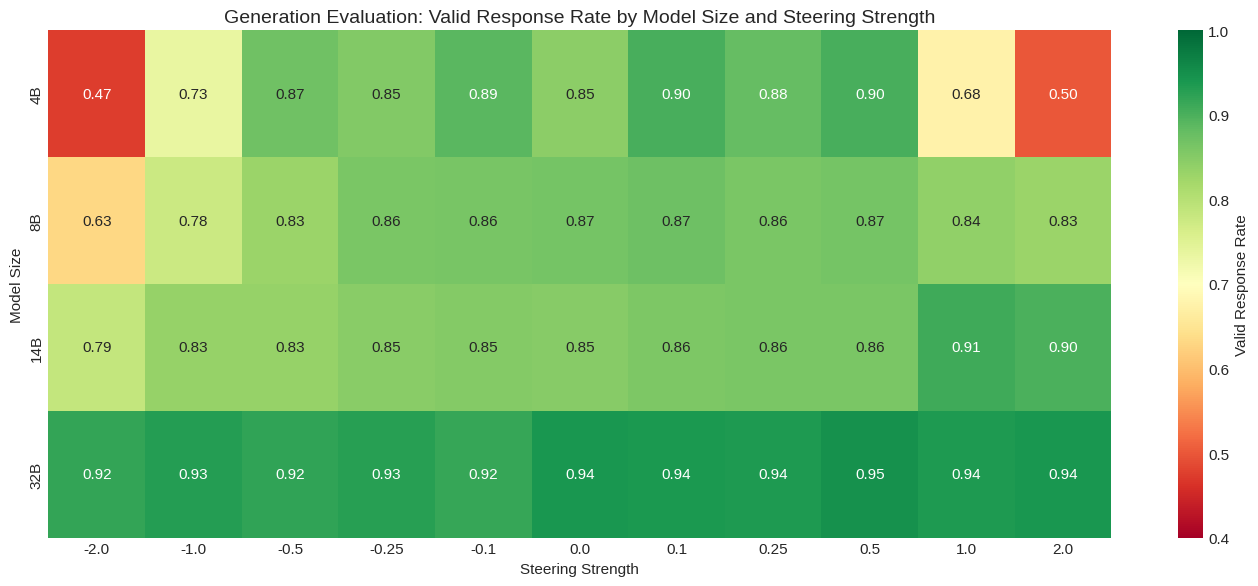


Key observations:
- Baseline (strength=0) validity: 87.5%
- Strong positive (strength=2) validity: 79.2%
- Strong negative (strength=-2) validity: 70.2%


In [33]:
# Valid response rate heatmap by model size and steering strength
valid_rates = gen_df.groupby(["model_size", "strength"])["is_valid"].mean().unstack()

fig, ax = plt.subplots(figsize=(14, 6))
sns.heatmap(valid_rates, annot=True, fmt=".2f", cmap="RdYlGn", vmin=0.4, vmax=1.0, ax=ax,
            cbar_kws={"label": "Valid Response Rate"})
ax.set_title("Generation Evaluation: Valid Response Rate by Model Size and Steering Strength", fontsize=14)
ax.set_ylabel("Model Size")
ax.set_xlabel("Steering Strength")
plt.tight_layout()
plt.savefig("../results/logit_diff_sweep/gen_valid_rate_heatmap.png", dpi=150, bbox_inches="tight")
plt.show()

print("\nKey observations:")
print(f"- Baseline (strength=0) validity: {valid_rates[0.0].mean():.1%}")
print(f"- Strong positive (strength=2) validity: {valid_rates[2.0].mean():.1%}")
print(f"- Strong negative (strength=-2) validity: {valid_rates[-2.0].mean():.1%}")

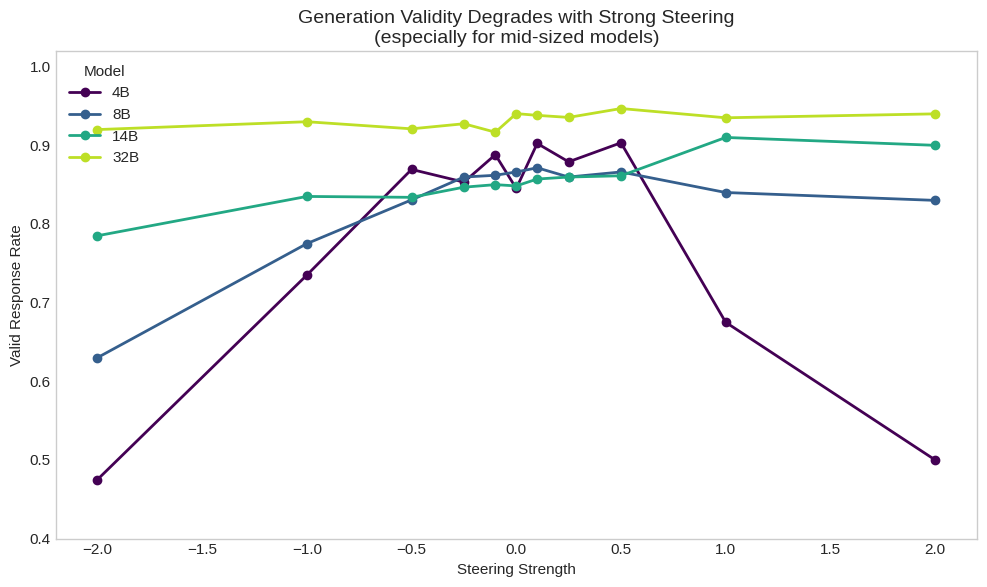

In [39]:
# Line plot: validity vs steering strength by model
fig, ax = plt.subplots(figsize=(10, 6))

colors = plt.cm.viridis(np.linspace(0, 0.9, len(GEN_MODELS)))
for i, model in enumerate(GEN_MODELS):
    if model in valid_rates.index:
        ax.plot(valid_rates.columns, valid_rates.loc[model], 
                marker='o', label=model, color=colors[i], linewidth=2)

ax.set_xlabel("Steering Strength")
ax.set_ylabel("Valid Response Rate")
ax.set_title("Generation Validity Degrades with Strong Steering\n(especially for mid-sized models)", fontsize=14)
ax.legend(title="Model", loc='upper left')
ax.set_ylim(0.4, 1.02)
ax.grid(False)
plt.tight_layout()
plt.savefig("../results/logit_diff_sweep/gen_valid_rate_by_strength.png", dpi=150, bbox_inches="tight")
plt.show()